In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


In [0]:

!ls /content/gdrive/My\ Drive/Colab\ Notebooks/
# /content/gdrive/My Drive/Colab Notebooks/
drive_path='/content/gdrive/My Drive/Colab Notebooks/webtoon'

35		  etc		   Semiconductor_Thick		    webtoon
education_sample  Satellite_Image  u-net_webtoon_test_1.15.0.ipynb


In [0]:
!pip install tensorflow==1.15.0
import tensorflow as tf
tf.__version__

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH = drive_path+'/input/stage1_train/'

TRAIN_PATH_IMG=TRAIN_PATH+'images/'
TRAIN_PATH_MASK=TRAIN_PATH+'masks/'

TEST_PATH = drive_path+'/input/stage1_test/'
TEST_PATH_IMG=TEST_PATH+'images/'
TEST_PATH_MASK=TEST_PATH+'masks/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [0]:
# Get train and test IDs
# train_ids = next(os.walk(TRAIN_PATH+'/images/'))[2]
# test_ids = next(os.walk(TEST_PATH+'/images/'))[2]
# train_ids = next(os.walk(TRAIN_PATH))[1][:-2]

# test_ids = next(os.walk(TEST_PATH))[1][:-2]
test_ids_img = next(os.walk(TEST_PATH_IMG))[2]
test_ids_img.sort()

test_ids_mask = next(os.walk(TEST_PATH_MASK))[2]
test_ids_mask.sort()

# train_ids = next(os.walk(TRAIN_PATH))[1][-2:]
train_ids_img = next(os.walk(TRAIN_PATH_IMG))[2]
train_ids_img.sort()
train_ids_mask = next(os.walk(TRAIN_PATH_MASK))[2]
train_ids_mask.sort()


In [0]:
train_ids_mask[:3]

['11_1_000_mask.jpg', '11_1_001_mask.jpg', '11_1_002_mask.jpg']

In [0]:
train_ids_img[:3]

['11_1_000.jpg', '11_1_001.jpg', '11_1_002.jpg']

In [0]:
# next(os.walk(TRAIN_PATH))[1][:-2]
next(os.walk(TRAIN_PATH))[1][-2:]


['fdda64c47361b0d1a146e5b7b48dc6b7de615ea80b31f01227a3b16469589528',
 'ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48']

In [0]:
for n in range(len(train_ids_img)):
    if(n<10):
        print(n, ":",train_ids_img[n],',',train_ids_mask[n])
    

0 : 11_1_000.jpg , 11_1_000_mask.jpg
1 : 11_1_001.jpg , 11_1_001_mask.jpg
2 : 11_1_002.jpg , 11_1_002_mask.jpg
3 : 11_1_003.jpg , 11_1_003_mask.jpg
4 : 11_1_004.jpg , 11_1_004_mask.jpg
5 : 11_1_005.jpg , 11_1_005_mask.jpg
6 : 11_1_006.jpg , 11_1_006_mask.jpg
7 : 11_1_007.jpg , 11_1_007_mask.jpg
8 : 11_1_008.jpg , 11_1_008_mask.jpg
9 : 11_1_009.jpg , 11_1_009_mask.jpg


In [0]:
# Get and resize train images and masks
    # mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    # mask = np.maximum(mask, mask_)
X_train = np.zeros((len(train_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids_img), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n in tqdm(range(len(train_ids_img)), total=len(train_ids_img)):
    path_img = TRAIN_PATH_IMG
    path_mask = TRAIN_PATH_MASK
    img_id_=train_ids_img[n]
    mask_id_=train_ids_mask[n]
    
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask_ = imread(path_mask + mask_id_,as_gray=True)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    Y_train[n] = mask_

# Get and resize test images
X_test = np.zeros((len(test_ids_img), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for  n in tqdm(range(len(test_ids_img)), total=len(test_ids_img)):
    path_img = TEST_PATH_IMG
    path_mask = TEST_PATH_MASK
    img_id_=test_ids_img[n]
    mask_id_=test_ids_mask[n]
    
    img = imread(path_img + img_id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 109/109 [02:09<00:00,  1.03s/it]

Getting and resizing test images ... 



100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Done!


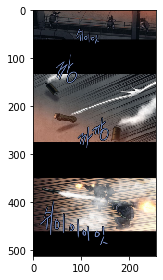

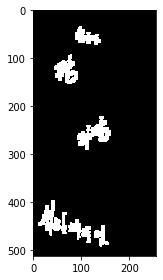

In [0]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids_img))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, 'accuracy'])
model.summary()

In [0]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.02, batch_size=16, epochs=100)
                    # , callbacks=[earlystopper, checkpointer])



Train on 106 samples, validate on 3 samples
Epoch 1/100
106/106 [==============================] - 22s 204ms/step - loss: 0.3733 - mean_iou: 0.3812 - acc: 0.8623 - val_loss: 0.1840 - val_mean_iou: 0.4727 - val_acc: 0.9562
Epoch 2/100
106/106 [==============================] - 5s 44ms/step - loss: 0.1936 - mean_iou: 0.4757 - acc: 0.9502 - val_loss: 0.1078 - val_mean_iou: 0.4780 - val_acc: 0.9756
Epoch 3/100
106/106 [==============================] - 5s 44ms/step - loss: 0.1598 - mean_iou: 0.4787 - acc: 0.9592 - val_loss: 0.0902 - val_mean_iou: 0.4793 - val_acc: 0.9756
Epoch 4/100
106/106 [==============================] - 5s 45ms/step - loss: 0.1476 - mean_iou: 0.4797 - acc: 0.9592 - val_loss: 0.0818 - val_mean_iou: 0.4798 - val_acc: 0.9756
Epoch 5/100
106/106 [==============================] - 5s 44ms/step - loss: 0.1349 - mean_iou: 0.4799 - acc: 0.9587 - val_loss: 0.1423 - val_mean_iou: 0.4800 - val_acc: 0.9756
Epoch 6/100
106/106 [==============================] - 5s 45ms/step - lo

In [0]:
# Predict on train, val and test
# model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

16/16 [==============================] - 0s 12ms/step


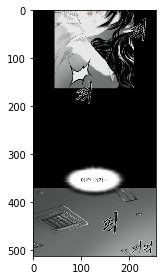

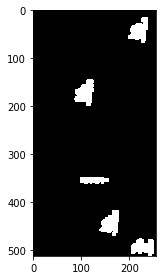

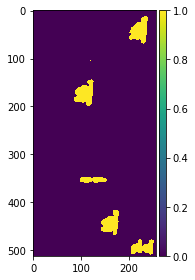

In [0]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

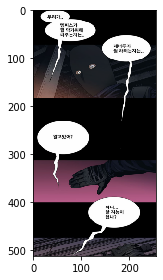

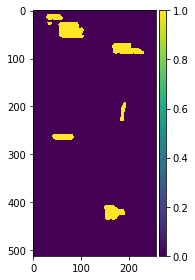

In [0]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()